In [3]:
import numpy as np
import astropy.units as u
import astropy.table as tbl
import matplotlib as plt

import matplotlib.pyplot as plt
import matplotlib
import astropy.constants as const
from astropy.constants import G
G = G.to(u.kpc*u.km**2/u.s**2/u.Msun)

from ReadFile import Read
from CenterOfMass import CenterOfMass

[-2.07  2.95 -1.45] kpc
[ 0.94  6.32 -1.35] km / s
[-377.66  611.43 -284.64] kpc [ 72.85 -72.14  49.  ] km / s
[ 72.85 -72.14  49.  ] km / s
[-476.22  491.44 -412.4 ] kpc
[ 44.42 101.78 142.23] km / s
44.42 km / s
769.098 kpc2
117.738 km2 / s2
201.083 kpc2
199.37 km2 / s2
M31 COM xyz position: [-377.66  611.43 -284.64] kpc and xyz velocity: [ 0.94  6.32 -1.35] km / s


In [65]:
class MassProfile:
    def __init__(self,galaxy,snap):
        ilbl = '000' + str(snap)
        ilbl = ilbl[-3:]
        self.filename = "%s_"%(galaxy) + ilbl + '.txt'
        self.time, self.total, self.data = Read(self.filename) 
        self.m = self.data['m']
        self.x = self.data['x']*u.kpc
        self.y = self.data['y']*u.kpc
        self.z = self.data['z']*u.kpc
        self.gname = galaxy
        self.G = const.G.to(u.kpc*u.km**2/u.s**2/u.Msun)
    def MassEnclosed(self,ptype,array):
        """
        Computs the mass enclosed within several radii of the cener 
        of mass of a galaxy of a given particle type and returns an array.
        inputs:
            ptype: The type of particle that is being measured
            array: the different radii that we are measuring the enclosed mass in
        outputs: 
            An array of enclosed masses for each radius in array
        
        """
        comp = CenterOfMass(self.filename, ptype)
        P = comp.COM_P(.1)
        # filters to the needed particle type
        #index = np.where(self.data['type'] == ptype)[0]
        index = np.where(self.data['type'] == ptype)
        x, y, z, m = self.x[index], self.y[index], self.z[index], self.m[index]
        # calculates the total distance from the center of mass
        r = np.sqrt((x - P[0])**2 + (y - P[1])**2 + (z - P[2])**2)
        #mG = self.m[index]
        total = []
        # uses a for loop to creat an array of the total mass enclosed
        for R in array:
            within = np.where(r<R*u.kpc)
            total.append (np.sum(m[within]))
        return total * u.Msun*1e10
    def MassEnclosedTotal(self, array):
        """
        Computs the total mass enclosed within a galaxy of all particle types combined.
        inputs:
            array: the different radii that we are measuring the enclosed mass in
        outputs:
            An array of enclosed masses for each radius in array
        """
        mass_halo = self.MassEnclosed(1,array)
        mass_disk = self.MassEnclosed(2,array)
        # filter to account for M33 not having a bulge
        if self.gname == "M33":
            mass_bulge = np.zeros(len(array)) 
        else:
            mass_bulge = self.MassEnclosed(3,array)
        #adds masses together
        totalm = mass_halo + mass_disk + mass_bulge
        return totalm
    
    def hernquist(self,r,a,Mhalo):
        """
        This function computes the mass enclosed within a given radius using 
        the theoretical profile M(r) = Mhalo*r**2/(a+r)**2
        inputs:
            r: the radius that the mass is enclosed in
            a: A scale factor
            Mhalo: the mass of the dark matter halo in the mass
        outputs:
            The theoretical halo mass
        """
        num = Mhalo*(r*u.kpc)**2 
        den = (a*u.kpc+r*u.kpc)**2
        M = num/den
        return M
    
    def CircularVelocity(self,ptype,array):
        """
        Computes the circular speed of the mass of a certain particle type 
        within a radius of a galaxy for each radii in an array
        inputs:
            ptype: The type of particle being measured
            array: The array of radii
        outputs: 
            An array of circular velocity for each radius in the
            array for the given particle type
        """
        from astropy.constants import G
        mass = self.MassEnclosed(ptype,array)
        G =G.to(u.kpc*u.km**2/u.s**2/u.Msun) 
        finalarray = []
        # for loop calculates the velocity for each value in mass and array and appends them to final array
        for i in range(len(array)):
            num1 = np.sqrt(mass[i]*G)
            den1 = np.sqrt(array[i]*u.kpc)
            CV = num1/den1
            finalarray.append(CV)
        
        return u.Quantity(finalarray)
    def CircularVelocityTotal(self,array):
        """
        Computes the total circular velocitiy of a galixy within different radii
        by calculating the total magnitue bewteen all 3 particle types
        inputs:
            array: The array of radii
        outputs:
            An array of circular velocity for each radius in the
            array
        """
        from astropy.constants import G
        types = [1,2,3]
        # creates an array where every value is zero
        CVT = np.zeros(len(array)) *u.km/u.s
        if self.gname != "M33":
            bulge_v = self.CircularVelocity(3,array)
        disk_v = self.CircularVelocity(2,array)
        halo_v = self.CircularVelocity(1,array)
        # filter for M33 that then rewrites the empy array to be the total velocity within each radius
        if self.gname == "M33":
            for i in range(len(array)):
                CVT[i] = np.sqrt (disk_v[i]**2+halo_v[i]**2)
        else:    
            for i in range(len(array)):
                CVT[i] = np.sqrt (bulge_v[i]**2+disk_v[i]**2+halo_v[i]**2)
        return CVT
    
    def HernquistVCirc(self,r,a,Mhalo):
        """
        Takes the hernquist value and uses it to compute the circular velocity
        using v = sqrt(G*M/r)
        inputs:
            r: the radius that the mass is enclosed in
            a: A scale factor
            Mhalo: the mass of the dark matter halo in the mass
        outputs:
            the circular velocity
        """
        Mass = self.hernquist(r,a,Mhalo)
        velocity = np.sqrt(G*Mass/(r*u.kpc))
        return velocity
    def MassProfileplt(self,array):
        """
        Makes a plot of the mass profile for each type of particle
        and the combined mass
        inputs:
            array: the array of radii
        """
        # defines each variable that needs to be plotted
        x = array
        y1 = self.MassEnclosed(1,array)
        y2 = self.MassEnclosed(2,array)
        if self.gname != "M33":
            y3 = self.MassEnclosed(3,array)
            plt.semilogy(x, y3, color='green', 
             linewidth=5, label='bulge')
        y4 = self.MassEnclosedTotal(array)
        plt.semilogy(x, y1, color='blue', 
         linewidth=5, label='halo')
        plt.semilogy(x, y2, color='red', 
         linewidth=5, label='disk')
        """plt.plot(x, y3, color='green', 
         linewidth=5, label='bulge')"""
        plt.semilogy(x, y4, color='black', 
         linewidth=5, label='total mass')
        plt.xlabel('Radius (kpc)',fontsize = 22)
        plt.ylabel('Mass (Msun)', fontsize = 22)
        #plt.show()
        
    def hernquistgraph(self,array,a):
        """
        Gets values from hernquist for each radii in the array and
        makes an array of the masses computed using hernquist. 
        This also plots the mass profiles of MassProfileplt and the best fit hernquist function()
        outputs:
            a graph of the massprofiles and the hernquest line of best fit
        """
        x = array
        y5 = np.zeros(len(array)) *u.Msun
        Mhalototal = self.MassEnclosed(1,array)
        #makes the hernquist line of best fit
        for R in range(len(array)):
            hernquistvalue = self.hernquist(array[R],0,Mhalototal[R])
            y5[R] = hernquistvalue
        slope, intercept = np.polyfit(x, y5, 1)
        y6 = slope * x + intercept
        plt.semilogy(x, y5, color="cyan",
         linewidth=3,label='hernquist best fit')
        plt.legend()
        plt.show
    def CVplt(self,array):
        """
        plots the rotation curve of a galaxy for the total rotation curve
        as well as the rotation curve for each particle type.
        inputs: the array of radii
        """
        # defines each variable that needs to be plotted
        x = array
        y1 = self.CircularVelocity(1,array)
        y2 = self.CircularVelocity(2,array)
        if self.gname != "M33":
            y3 = self.CircularVelocity(3,array)
            plt.plot(x, y3, color='green', 
             linewidth=5, label='bulge')
        y4 = self.CircularVelocityTotal(array)
        plt.plot(x, y1, color='blue', 
         linewidth=5, label='halo')
        plt.plot(x, y2, color='red', 
         linewidth=5, label='disk')
        plt.plot(x, y4, color='black', 
         linewidth=2, label='total velocity')
        plt.xlabel('Radius (kpc)',fontsize = 22)
        plt.ylabel('Velocity (km/s)', fontsize = 22)
        
        #plt.plot()
    def hernquistVgraph(self,array,a):
        """
        Gets values from HernquistVCirc for each radii in the array and
        makes an array of the velocities computed using hernquist. 
        This also plots the rotation curves of CVplt and the best fit hernquist circular speed
        outputs:
            a graph of the circular speeds and the hernquist circular speed line of best fit
        """
        x = array
        y5 = np.zeros(len(array)) *u.km/u.s
        Mhalototal = self.MassEnclosed(1,array)
        #makes the hernquist circular velocity line of best fit
        for R in range(len(array)):
            hernquistvalue = self.HernquistVCirc(array[R],a,Mhalototal[R])
            y5[R] = hernquistvalue
        slope, intercept = np.polyfit(x, y5, 1)
        y6 = slope * x + intercept
        plt.plot(x, y5, color="cyan",
         linewidth=5,label='hernquist best fit')
        plt.legend()
        plt.show
        

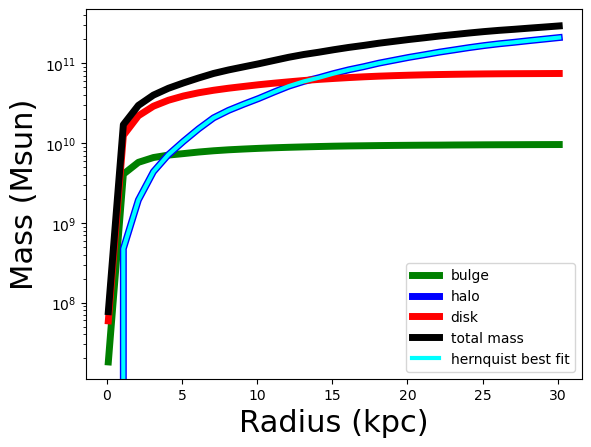

In [67]:
MW = MassProfile("MW", 0)
R = np.arange(0.1, 30.5, 1)
MW.MassProfileplt(R)
MW.hernquistgraph(R,0)
# hernquist = 0

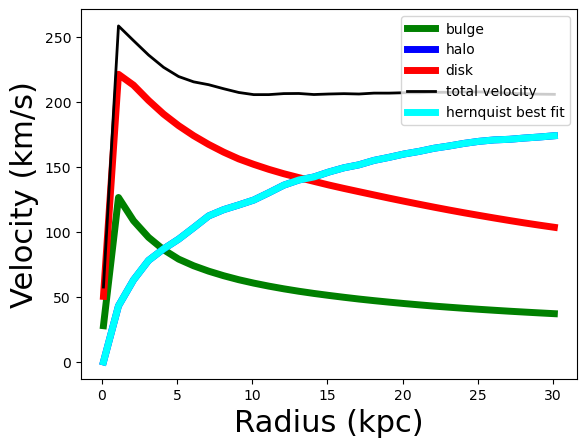

In [68]:
MW = MassProfile("MW", 0)
R = np.arange(0.1, 30.5, 1)
MW.CVplt(R)
MW.hernquistVgraph(R,0)

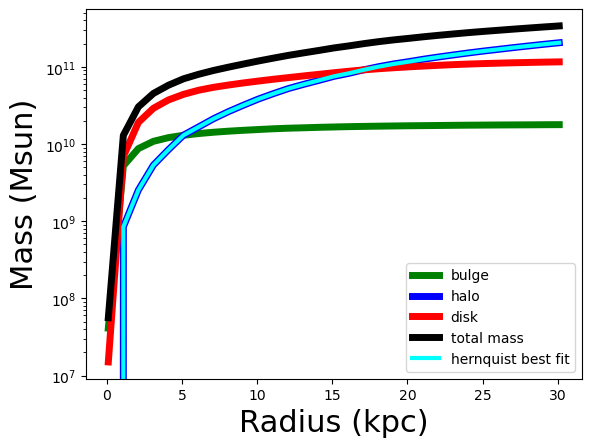

In [69]:
M31 = MassProfile("M31", 0)
R = np.arange(0.1, 30.5, 1)
M31.MassProfileplt(R)
M31.hernquistgraph(R,0)

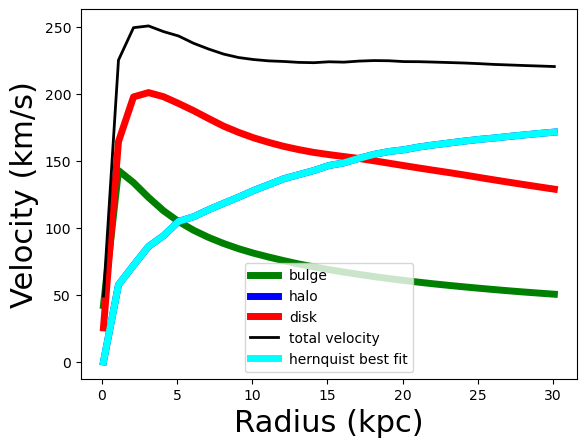

In [70]:
M31 = MassProfile("M31", 0)
R = np.arange(0.1, 30.5, 1)
M31.CVplt(R)
M31.hernquistVgraph(R,0)

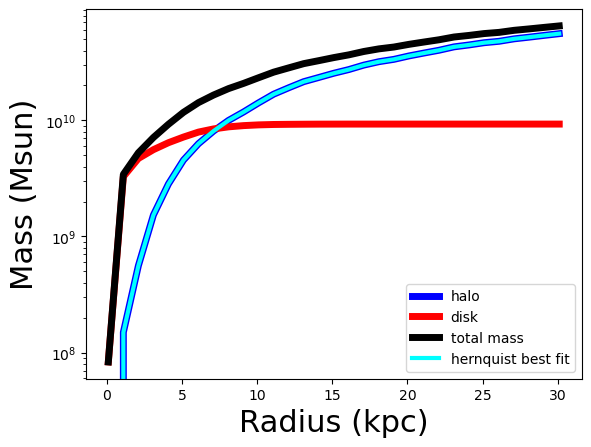

In [71]:
M33 = MassProfile("M33", 0)
R = np.arange(0.1, 30.5, 1)
M33.MassProfileplt(R)
M33.hernquistgraph(R,0)

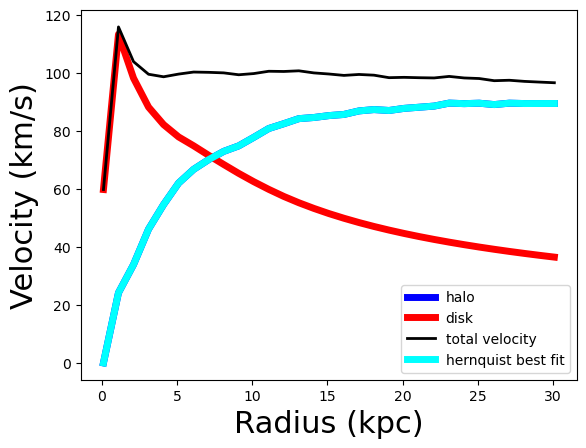

In [81]:
M33 = MassProfile("M33", 0)
R = np.arange(0.1, 30.5, 1)
M33.CVplt(R)
M33.hernquistVgraph(R,0)